<a href="https://colab.research.google.com/github/natbugreal/datascience/blob/main/Natalia_Perez_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [3]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)
#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
#identifies all the different amino acids in our data set
#and stores that information, plus original info, in the variable aa_encode
aa_encode = pd.Categorical(cs_data['aa'])
#Replaces all the amino acid names with a number in the variable aa_idx
aa_idx = aa_encode.codes
#stores the category names in a dictionary
#this dictionary format is required
#for pymc to properly read the categories
aa_coords = {"aa": aa_encode.categories}

In [4]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

Output()

Output()

In [5]:
with pm.Model(coords=aa_coords) as cs_hstu_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', nu=5, mu = 0, sigma = 10)
    μ_sd = pm.HalfStudentT('μ_sd', nu=5, sigma = 10)
    ν_nu = pm.HalfStudentT('ν_nu', nu=5, sigma=10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  nu = ν_nu,
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfStudentT('σ', nu = 5, sigma = 10,
                      dims = "aa")

    ν = pm.HalfStudentT('ν', nu = 5, sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.StudentT('y',
                  nu = ν[aa_idx],
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical, stu for student T version
    idata_cs_hstu = pm.sample()

Output()

Output()

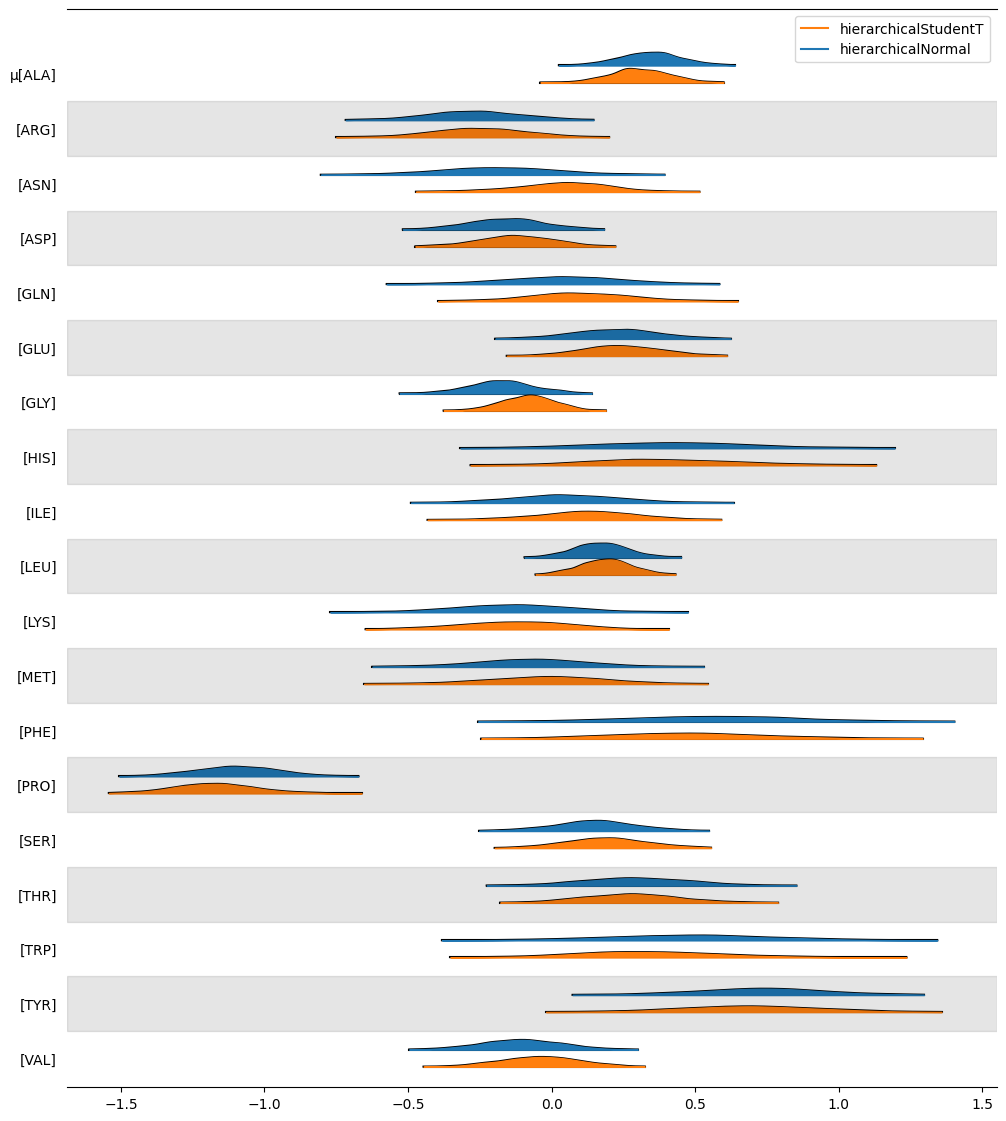

In [6]:
axes = az.plot_forest([idata_cs_h, idata_cs_hstu], kind="ridgeplot",
                      model_names=['hierarchicalNormal', 'hierarchicalStudentT'],
                      var_names='μ', combined=True, figsize=(12, 14),hdi_prob=0.997)

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

<Axes: xlabel='y'>

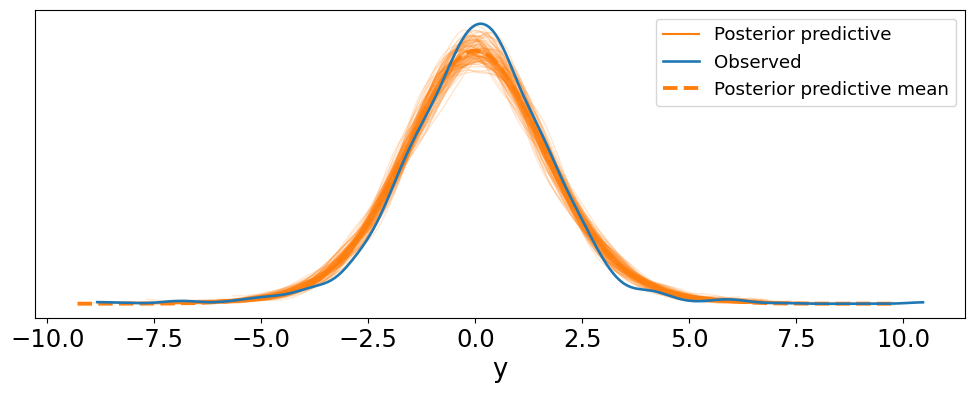

In [7]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Output()

(-10.0, 10.0)

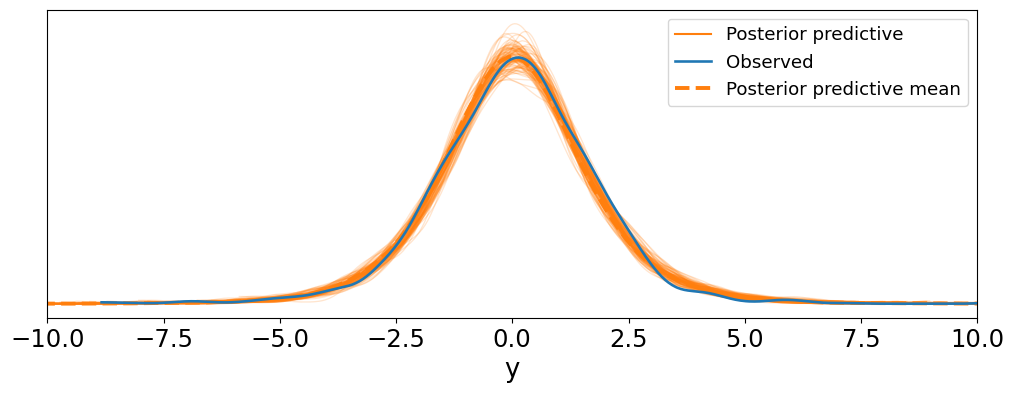

In [8]:
pm.sample_posterior_predictive(idata_cs_hstu, model=cs_hstu_model, extend_inferencedata=True)
ax=az.plot_ppc(idata_cs_hstu, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(-10, 10)


I believe when looking for a model of best fit, the studentT and HalfStudentT priors do a better job at fitting the data in the dataset. Its prevalent in the studentT where the peak near 3 lies.


**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [9]:
#load the data from my github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [10]:
with pm.Model(coords = sccr_coords) as sccr_model:

    # Parameters for positions
    μ_p = pm.Beta('μ_p', alpha = 2, beta = 20, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.98)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.001 1.005 1.0 1.001 ... 1.0 0.9998 1.001
    μ_p      (pos) float64 32B 1.008 1.004 1.033 1.003
    ν_p      (pos) float64 32B 1.004 1.008 1.076 1.004

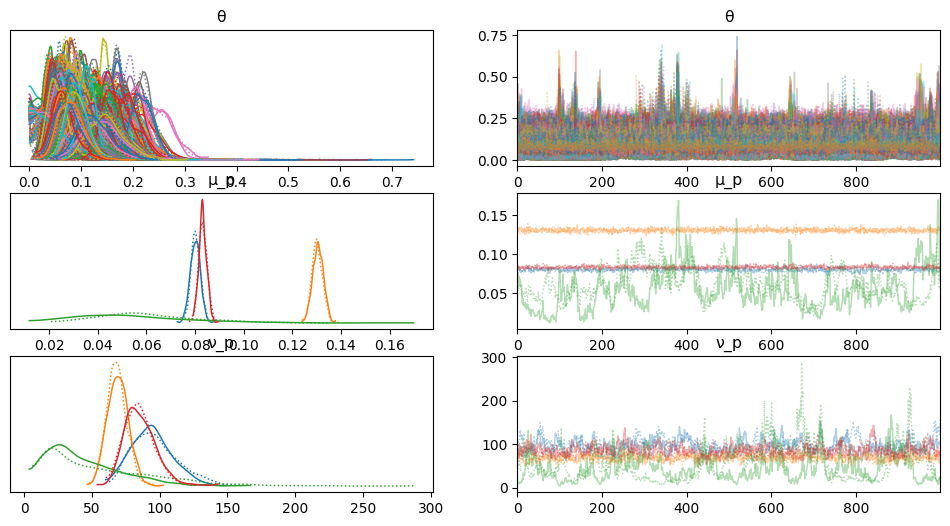

In [11]:
az.plot_trace(idata_sccr)
az.rhat(idata_sccr)

The non-hierarchical model's numbers look better than the fancy hierarchical one we saw before. Most of the numbers are closer to what we want (between 1 and 1.001). Even the goalie numbers, which aren't perfect, are way better than what we saw earlier.
When we look at the squiggly lines on the graphs, they kinda look the same for both models. In one graph, the red line goes higher in the simpler model, but all the lines are pretty close together. In another graph, the simpler model looks neater, except for the green part.
Basically, the simpler model seems to be doing a better job overall, even though it's not perfect.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

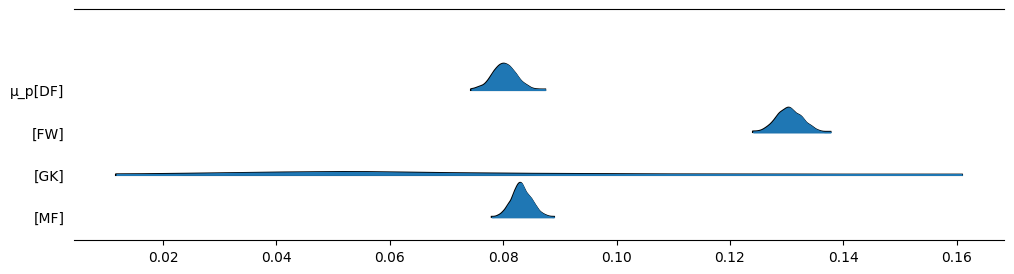

In [12]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

these models are better because they are more narrow and better to look at

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [13]:
sccr_data_noG = sccr_data[sccr_data.position != 'GK'].copy()
sccr_data_noG['position'] = pd.Categorical(sccr_data_noG['position'])
sccr_data_noG['position'] = sccr_data_noG['position'].cat.remove_unused_categories()

In [14]:
pos_idx_noG = sccr_data_noG.position.cat.codes.values

pos_codes_noG = sccr_data_noG.position.cat.categories

sccr_coords_noG = {"pos": pos_codes_noG}

print(pos_codes_noG)
print(sccr_coords_noG)

Index(['DF', 'FW', 'MF'], dtype='object')
{'pos': Index(['DF', 'FW', 'MF'], dtype='object')}


In [15]:
with pm.Model(coords = sccr_coords_noG) as sccr_model_noG:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx_noG], nu = ν_p[pos_idx_noG])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data_noG.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data_noG.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_noG = pm.sample(target_accept = 0.95)



Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([<Axes: >], dtype=object)

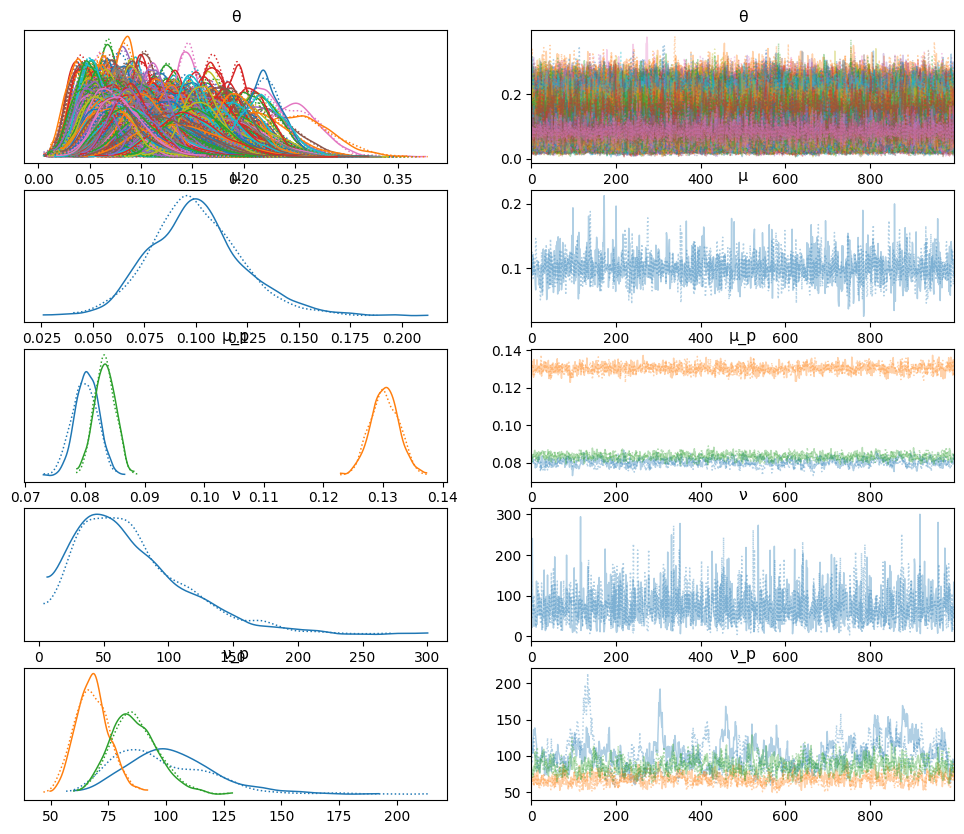

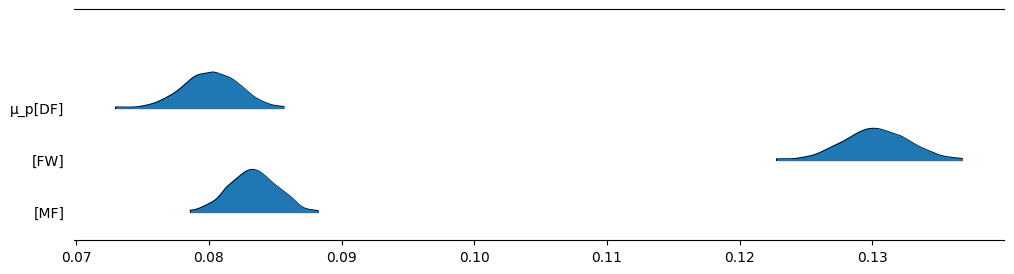

In [16]:
az.plot_trace(idata_sccr_noG)
az.rhat(idata_sccr_noG)
az.plot_forest(idata_sccr_noG, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

dropping GKs makes things easier but leaves out some important info about that position in soccer!The model without GKs was easier because it has fewer players to deal with, making it simpler and faster for the computer to work with.
We miss out on understanding goalkeepers and how they fit into the game. The model doesn't show the whole picture of soccer.
The model works better and faster without GKs, giving clearer results for other players like defenders and forwards.
